In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = os.path.join(os.getcwd(), 'df_clean.csv')
df_clean = pd.read_csv(data_path, delimiter = ',', encoding='latin-1', decimal=",")
df_clean.drop(['Unnamed: 0'], axis=1, inplace=True)
df_clean = df_clean[df_clean['Descripcio_victimitzacio']!='Mort']

# Labels are the values we want to predict
Y =  df_clean['Descripcio_victimitzacio'] 
Y = Y.replace({'Mort': 2}, regex=True)
Y = Y.replace({'Ferit lleu': 1}, regex=True)
Y = Y.replace({'Ferit greu': 0}, regex=True)

# Remove the labels from the features
# axis 1 refers to the columns
X = df_clean.drop(columns = ['Num_Greus', 'Num_Lleus', 'Num_Morts', 
                                      'Codi_expedient','Descripcio_victimitzacio',
                                     'Descripcio_tipus_persona','Descripcio_tipus_de_vehicle',
                                     'Longitud','Latitud'], axis = 1)
# Saving feature names for later use
feature_list = list(X.columns)


num_columns = len(X.columns)
pd.set_option("display.max_columns", num_columns)
X


,Edat,Codi_barri,Codi_carrer,Hora_de_dia,Mes_de_any,Dia_de_mes,Autobus,Bicicleta,Ciclomotor,Furgoneta,Motocicleta,Taxi,Turisme,Num_Victimes,Num_Vehicles_Implicats,Poblacio,Nombre_vehicles_parc,Any,Sortida_Sol,Posta_Sol,Dif_PostaoSortida_Sol,Num_Semaf_Barri,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant
0,50,26,187105,4,1,1,0,0,0,0,0,0,1,1,1,47753,26740,2017,8,17,4,3620,0.11435,9.1,70,0.0,2.4,5.5,1,0,0
1,27,6,89004,7,1,1,0,0,0,0,1,0,0,1,2,51651,6904,2017,8,17,1,3058,0.01777,8.0,71,0.0,2.6,4.7,1,0,0
2,34,6,89004,3,8,3,0,0,0,0,0,1,0,1,2,51651,0,2017,6,21,3,3058,0.01777,27.3,74,0.0,0.9,2.9,0,1,0
3,40,66,243206,7,1,1,0,0,1,0,0,0,0,2,3,15204,504,2017,8,17,1,3594,0.03419,8.0,71,0.0,2.6,4.7,0,1,0
4,37,66,243206,7,1,1,0,0,1,0,0,0,0,2,3,15204,504,2017,8,17,1,3594,0.03419,8.0,71,0.0,2.6,4.7,1,0,0
5,35,18,270209,14,1,1,0,0,1,0,0,0,0,1,2,41244,1432,2017,8,17,3,1462,0.10208,13.0,55,0.0,1.9,4.1,1,0,0
6,50,18,270209,16,1,1,0,0,0,0,1,0,0,1,2,41244,5241,2017,8,17,1,1462,0.10208,11.8,61,0.0,1.9,3.9,1,0,0
7,24,18,270209,22,3,24,0,0,0,0,0,1,0,2,2,41244,0,2017,6,19,3,1462,0.10208,6.9,98,3.5,4.9,10.2,0,1,0
8,47,18,270209,22,3,24,0,0,0,0,0,1,0,2,2,41244,0,2017,6,19,3,1462,0.10208,6.9,98,3.5,4.9,10.2,1,0,0
9,29,67,700662,15,1,1,0,1,0,0,0,0,0,1,2,9404,0,2017,8,17,2,1725,0.03664,12.9,56,0.0,1.7,3.9,1,0,0


In [14]:
# split into train and test

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                Y, 
                                                train_size=0.7, 
                                                random_state = 0
                                               )

# Feature Scaling
sc = StandardScaler()  
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)  
Xtest = sc.transform(Xtest)  
Xtrain

array([[ 0.2434755 ,  1.83609896,  2.33593595, ...,  0.64866403,
        -0.49288726, -0.33462683],
       [-0.49889117,  0.12218056,  0.51526343, ...,  0.64866403,
        -0.49288726, -0.33462683],
       [ 0.2434755 , -0.37395372, -0.96972218, ...,  0.64866403,
        -0.49288726, -0.33462683],
       ...,
       [ 0.36720328,  0.70852106,  0.271159  , ...,  0.64866403,
        -0.49288726, -0.33462683],
       [ 1.41888941, -0.28374749, -0.50089898, ...,  0.64866403,
        -0.49288726, -0.33462683],
       [ 2.77989498, -0.64457242, -0.41782194, ...,  0.64866403,
        -0.49288726, -0.33462683]])

In [4]:
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
smt = SMOTETomek(ratio = 0.5, random_state=42)
Xtrain, ytrain = smt.fit_resample(Xtrain, ytrain)

In [15]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [18]:
# Create the neural network
mlp = MLPClassifier(
#                     solver='adam', 
#                     alpha=1e-5, # Learning Rate
#                     hidden_layer_sizes=(400,1000,100), 
                    max_iter=2000, 
                    random_state=42,
#                     learning_rate = 'adaptive',
                   )


# GridSearch
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# Train the neural network
clf.fit(Xtrain, ytrain)

# print the train and test accuracy
train_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)

print('Train Accuracy: {:.5f}'.format(train_accuracy)) 
print('Train Accuracy: {:.5f}'.format(test_accuracy)) 

Train Accuracy: 0.98077
Train Accuracy: 0.97879


In [21]:
from sklearn.metrics import classification_report
print(classification_report(ytest,clf.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.98      1.00      0.99      2400

   micro avg       0.98      0.98      0.98      2452
   macro avg       0.49      0.50      0.49      2452
weighted avg       0.96      0.98      0.97      2452



In [22]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="prior").fit(Xtrain, ytrain) 
pred_y_d = dummy_classifier.predict(Xtest)
print('Dummy Classifier accuracy on the test set: {:.5f}'.format(accuracy_score(ytest,pred_y_d)))


Dummy Classifier accuracy on the test set: 0.97879


In [23]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

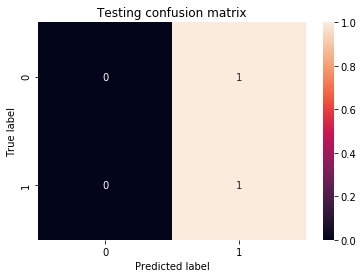

In [25]:
cm = confusion_matrix(ytest,clf.predict(Xtest))
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=clf.classes_, title='Testing confusion matrix')

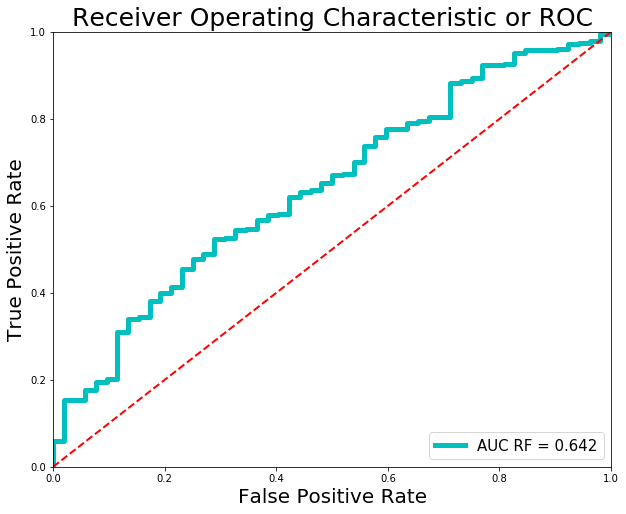

In [27]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

### RANDOM FOREST
probs = clf.predict_proba(Xtest)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

### PLOT
fig = plt.figure(figsize=(10,8))

plt.title('Receiver Operating Characteristic or ROC',fontsize=25)
plt.plot(fpr, tpr, 'c', label = 'AUC RF = %0.3f' % roc_auc, linewidth = 5)
plt.legend(loc = 'lower right',fontsize=15)
plt.plot([0, 1], [0, 1],'r--',linewidth = 2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.show()